File name: KMeans_feature_clustering

Description: this file contains the code for KMeans clustering the using the botanicals and then compounds within each recipes.

In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from statistics import mean
import json

# get custom data set with all samples

In [2]:
df = pd.read_excel("../../data/refinded_Gin(Nov2022).xlsm")
#aling column titles
df.columns = df.iloc[7]
#delete null rows 
df.drop([0,1,2,3,4,5,6,7,560,561,562], inplace=True)
#drop useless columns
with open("../../data/removed_coloumns.txt") as f:
    drop_these = f.read().splitlines()
df.drop(drop_these, axis=1, inplace=True)
#df.to_csv("../../data/unlabelled_data.csv", index=False)
#drop juniper as this is a required in all gins 
df_new = df.drop(labels=["Juniper"], axis=1)


In [ ]:
botanicals = df_new.iloc[:,25:277]

compounds = df_new.iloc[:,277:]
#normalise compounds 
# Min-Max Normalization (scaling between 0 and 1)
# for column in compounds.columns:
    # compounds[column] = (compounds[column] - compounds[column].min()) / (compounds[column].max() - compounds[column].min())
botanicals.head()

/tmp/ipykernel_101667/977446278.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds[column] = (compounds[column] - compounds[column].min()) / (compounds[column].max() - compounds[column].min())


7,LD (F),Rosewater,Honey,Lemon Myrtle,Herb-Robert,Camomile,Rose,Jasmine,Passion Flower,Acacia Flower,...,Clementine,Tangerine,Black Lemon,Buddha's Hand,Calamansi,Jaffa Cakes,Treacle,Bee Pollen,Collagen,Angostura Bitters
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
compounds.head()

7,2-methyl-3-pentanone [Minty],prenyl ethyl ether [Fruity],"2,4-dimethyl-3-pentanone [Acetone]",methyl 2-methylbutanoate [Fruity],Isobutyl acetate [Fruity],2-Butanol [Fruity],(L)-a-pinene [Herbal],"a-Pinene, (D)- [Herbal]",a-Pinene [Herbal],alpha-thujene [Woody],...,"Cinnamaldehyde, (E)- [Spicy]",Cinnamaldehyde [Spicy],Methyl (E)-cinnamate [Balsamic],Methyl cinnamate [Balsamic],Thymol [Herbal],g-decalactone [Fruity],Eugenol [Spicy],T-muurolol [Herbal],Carvacrol [Spicy],Myristicin [Spicy]
8,0,82.201878,0,2.383065,1781.17628,0,39710.132116,39710.409177,39710.409177,39712.224796,...,0.6132,0.6132,0.454945,0.454945,0.911189,1.022261,0.320606,0.647581,0.617165,0.08332
9,0,57.167923,0,2.168837,2104.660213,0,50883.322641,50889.675631,50889.675631,50889.957623,...,0.274499,0.274499,0.604225,0.604225,0.48376,0,0.188269,0.420474,0.231384,0.106196
10,0,0,0,3.206824,0,0,2455.328189,2456.263516,2456.263516,2456.436679,...,1.067534,1.067534,0.155828,0.976642,0.364647,0.758662,0.231003,0.635617,0.845603,0.224177
11,0,18.330532,63.570718,2.700928,173.26718,0,4090.230765,4091.393223,4091.393223,4091.733783,...,0.222037,0.222037,0.364195,0.364195,0.313862,0.376746,0.187963,0.530723,0.240971,0.038429
12,1.623232,2.209863,0,11.240266,0,0,8297.117366,8297.586783,8297.586783,8297.814111,...,1.636594,1.636594,0.559978,0.559978,0.809132,0,33.050113,0.358779,0.281091,1.861683


# try k  means botanicals

In [5]:
# Assuming you have your data in a variable called data

K = range(2, 19)
random_states = [np.random.randint(50),np.random.randint(50,100),np.random.randint(101,150),np.random.randint(151,200),np.random.randint(201,250)]
inertia = [[],[],[],[],[]]
silhouette_scores = [[],[],[],[],[]]    
davies_bouldin_scores = [[],[],[],[],[]]


for index, random_state in enumerate(random_states):
    for k in K:
        #print(index,"  ----  ",k)
        kmeans = KMeans(n_clusters=k, random_state=random_state).fit(botanicals)
        inertia[index].append(kmeans.inertia_)
        #print(kmeans.inertia_)
        score = silhouette_score(botanicals, kmeans.labels_)
        silhouette_scores[index].append(score)
        db_score = davies_bouldin_score(botanicals, kmeans.labels_)
        davies_bouldin_scores[index].append(db_score)
        #print(score)

/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

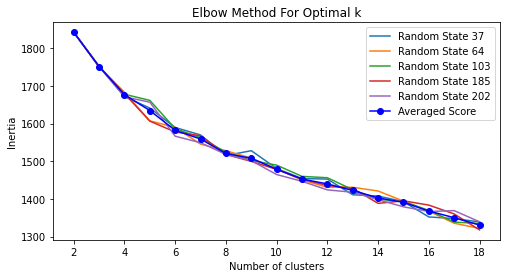

In [6]:
scores = {
    "botanicals": {
    },
    "compounds": {
    }
}

plt.figure(figsize=(8, 4))
avg = []
for index, i in enumerate(inertia):
    plt.plot(K, i, label=f"Random State {random_states[index]}")

#get average
for i in range(len(K)):
    avg.append(mean([iner[i] for iner in inertia]))   
    
plt.plot(K, avg, "bo-",label=f"Averaged Score")

scores["botanicals"]["inertia"] = avg

#plt.plot(K, inertia, label=f"Random State")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

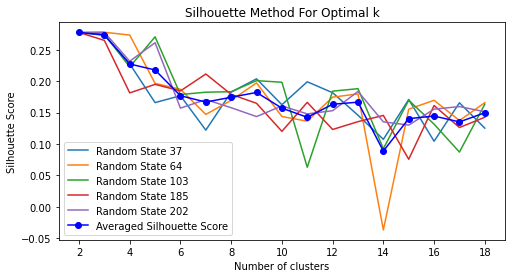

In [7]:
plt.figure(figsize=(8, 4))
for index, silhouette in enumerate(silhouette_scores):
    plt.plot(K, silhouette, label=f"Random State {random_states[index]}")

avg=[]
#get average
for i in range(len(K)):
    avg.append(mean([sil[i] for sil in silhouette_scores]))   
     
plt.plot(K, avg, "bo-",label=f"Averaged Silhouette Score")

scores["botanicals"]["silhouette_scores"] = avg

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.legend()
plt.show()

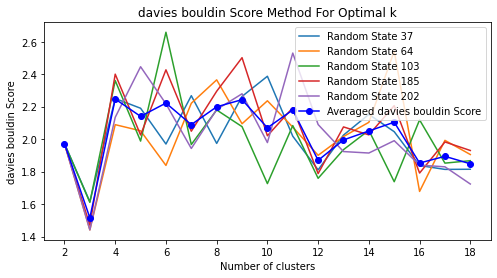

In [8]:
plt.figure(figsize=(8, 4))
for index, db in enumerate(davies_bouldin_scores):
    plt.plot(K, db, label=f"Random State {random_states[index]}")

avg=[]
#get average
for i in range(len(K)):
    avg.append(mean([db[i] for db in davies_bouldin_scores]))   
     
plt.plot(K, avg, "bo-",label=f"Averaged davies bouldin Score")

scores["botanicals"]["davies_bouldin_scores"] = avg

plt.xlabel('Number of clusters')
plt.ylabel('davies bouldin Score')
plt.title('davies bouldin Score Method For Optimal k')
plt.legend()
plt.show()

# kmeans compounds

In [4]:
K = range(2, 19)
random_states = [np.random.randint(50),np.random.randint(50,100),np.random.randint(101,150),np.random.randint(151,200),np.random.randint(201,250)]
inertia = [[],[],[],[],[]]
silhouette_scores = [[],[],[],[],[]]
davies_bouldin_scores = [[],[],[],[],[]]


for index, random_state in enumerate(random_states):
    for k in K:
        #print(index,"  ----  ",k)
        kmeans = KMeans(n_clusters=k, random_state=random_state).fit(compounds)
        inertia[index].append(kmeans.inertia_)
        #print(kmeans.inertia_)
        score = silhouette_score(compounds, kmeans.labels_)
        silhouette_scores[index].append(score)
        db_score = davies_bouldin_score(compounds, kmeans.labels_)
        davies_bouldin_scores[index].append(db_score)
        #print(score)

/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

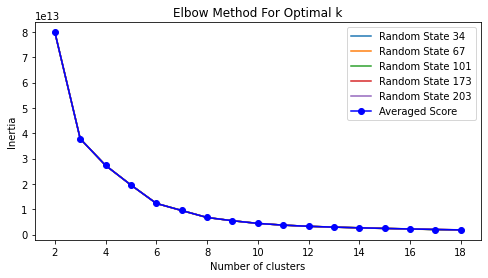

In [10]:
plt.figure(figsize=(8, 4))
avg = []
for index, i in enumerate(inertia):
    plt.plot(K, i, label=f"Random State {random_states[index]}")

#get average
for i in range(len(K)):
    avg.append(mean([iner[i] for iner in inertia]))   
     
plt.plot(K, avg, "bo-",label=f"Averaged Score")

scores["compounds"]["inertia"] = avg
    

#plt.plot(K, inertia, label=f"Random State")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.legend() 
plt.show()

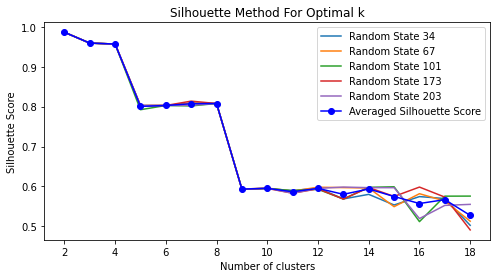

In [11]:
plt.figure(figsize=(8, 4))
for index, silhouette in enumerate(silhouette_scores):
    plt.plot(K, silhouette, label=f"Random State {random_states[index]}")

avg=[]
#get average
for i in range(len(K)):
    avg.append(mean([sil[i] for sil in silhouette_scores]))   
     
plt.plot(K, avg, "bo-",label=f"Averaged Silhouette Score")

scores["compounds"]["silhouette_scores"] = avg

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.legend()
plt.show()

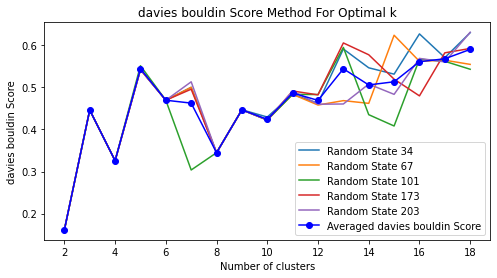

In [12]:
plt.figure(figsize=(8, 4))
for index, db in enumerate(davies_bouldin_scores):
    plt.plot(K, db, label=f"Random State {random_states[index]}")

avg=[]
#get average
for i in range(len(K)):
    avg.append(mean([db[i] for db in davies_bouldin_scores]))   
     
plt.plot(K, avg, "bo-",label=f"Averaged davies bouldin Score")

scores["compounds"]["davies_bouldin_scores"] = avg

plt.xlabel('Number of clusters')
plt.ylabel('davies bouldin Score')
plt.title('davies bouldin Score Method For Optimal k')
plt.legend()
plt.show()

In [16]:
with open('../../data/json/KMeans_features.json', 'w') as f:
    json.dump(scores, f)  

In [ ]:
tsne = TSNE(n_components=2, random_state=150)
tsne_results = tsne.fit_transform(botanicals)
x = tsne_results[:, 0]
y = tsne_results[:, 1]

/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0, 0.5, 'Number of Instances')

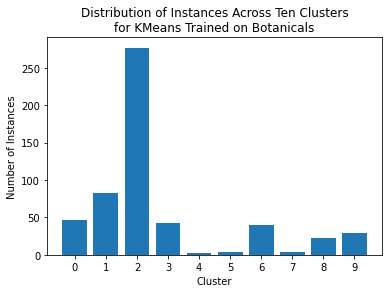

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(botanicals)
labels = kmeans.labels_
category_dist = np.unique(labels, return_counts=True)
with open('../../data/json/KMeans_botanicals_labels.json', 'w') as f:
    json_file =  {'labels': [x.tolist() for x in category_dist]}
    json.dump(json_file, f)
plt.bar(category_dist[0], category_dist[1])
plt.xlabel("Cluster")
plt.xticks(category_dist[0])
plt.title("Distribution of Instances Across Ten Clusters\nfor KMeans Trained on Botanicals")
plt.xlabel("Cluster")
plt.ylabel("Number of Instances")

Text(0, 0.5, 't-SNE Component 2')

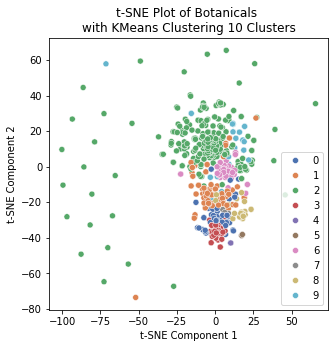

In [ ]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=x, y=y, hue=kmeans.labels_, palette="deep", legend="full")
plt.title("t-SNE Plot of Botanicals \nwith KMeans Clustering 10 Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0, 0.5, 'Number of Instances')

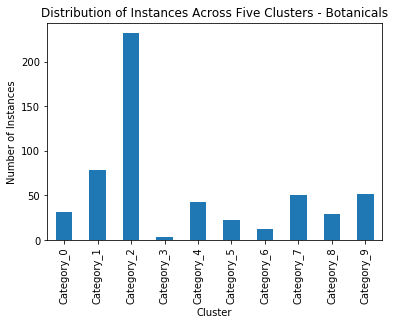

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=223).fit(botanicals)

with open('../../data/json/KMeans_labels.json', 'w') as f:
    json.dump({"labels" : kmeans.labels_.tolist()}, f)
    
    
kmeans_4cats = df.assign(Category = kmeans.labels_)
kmeans_4cats = pd.get_dummies(kmeans_4cats, columns=["Category"], dtype=int)
bar = kmeans_4cats.iloc[:,-10:].sum()
bar.plot.bar()
plt.title("Distribution of Instances Across Five Clusters - Botanicals")
plt.xlabel("Cluster")
plt.ylabel("Number of Instances")


In [10]:
kmeans.labels_.shape

(552,)

In [5]:
tsne = TSNE(n_components=2, random_state=150)
tsne_results = tsne.fit_transform(compounds)
x = tsne_results[:, 0]
y = tsne_results[:, 1]

Text(0, 0.5, 't-SNE Component 2')

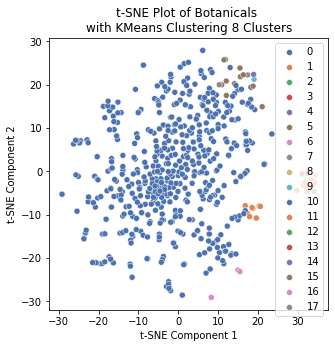

In [6]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=x, y=y, hue=kmeans.labels_, palette="deep", legend="full")
plt.title("t-SNE Plot of Botanicals \nwith KMeans Clustering 8 Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

/home/michael/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0, 0.5, 'Number of Instances')

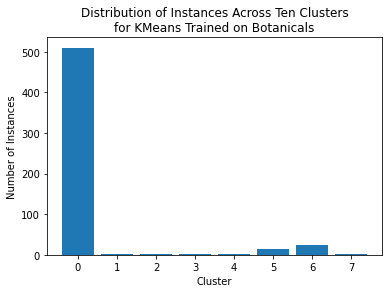

In [5]:
kmeans = KMeans(n_clusters=8, random_state=42).fit(compounds)
labels = kmeans.labels_
category_dist = np.unique(labels, return_counts=True)
with open('../../data/json/KMeans_compounds_labels.json', 'w') as f:
    json_file =  {'labels': [x.tolist() for x in category_dist]}
    json.dump(json_file, f)
plt.bar(category_dist[0], category_dist[1])
plt.xlabel("Cluster")
plt.xticks(category_dist[0])
plt.title("Distribution of Instances Across Ten Clusters\nfor KMeans Trained on Botanicals")
plt.xlabel("Cluster")
plt.ylabel("Number of Instances")